In [1]:
import numpy as np
import scipy as scp
import pandas as pd

import matplotlib.pyplot as plt

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split  
from sklearn.metrics import r2_score

In [2]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [12]:
import seaborn as sns

In [3]:
# Computation of the Probability of Collision.

def algorithm1(sigmaX,sigmaY,xm,ym,R,n):
    
    p = 1/(2*sigmaY**2);
    phi = 1-sigmaY**2/sigmaX**2;
    omegaX = xm**2/(4*sigmaX**4);
    omegaY = ym**2/(4*sigmaY**4);
    alpha0 = 1/(2*sigmaX*sigmaY)*np.exp(-1/2*(xm**2/sigmaX**2+ym**2/sigmaY**2));
    
    a = p*(phi/2+1)+omegaX+omegaY;
    b = p**2*((phi**2)/2+1)+2*p*phi*omegaX;
    
    c = np.zeros(n);
    
    c[0] = alpha0*R**2;
    c[1] = (c[0]*R**2)/2*a;
    c[2] = (c[0]*R**4)/3*(a**2+b);
    c[3] = (c[0]*R**6)/12*(a**3+3*a*b+2*(p**3*((phi**3)/2+1)+3*p**2*phi**2*omegaX));
    
    for k in range(n-4):
        c[k+4] = -c[k]*(R**8*p**3*phi**2*omegaY)/((k+2)*(k+3)*(k+4)**2*(k+5))+c[k+1]*(R**6*p**2*phi*(p*phi*(k+5/2)+2*omegaY*(phi/2+1)))/((k+3)*(k+4)**2*(k+5))-c[k+2]*(R**4*p*(p*phi*(phi/2+1)*(2*k+5)+phi*(2*omegaY+3*p/2)+omegaX+omegaY))/((k+4)**2*(k+5))+c[k+3]*(R**2*(p*(2*phi+1)*(k+3)+a))/((k+4)*(k+5))
    
    s=0;
    
    for k in range(n):
        s = s+c[k];
    
    Pc = 0;
    Pc = np.exp(-p*R**2)*s;
    
    return Pc;

In [4]:
# Computation of probability of collision with guaranteed accuracy.

def algorithm2(sigmaX,sigmaY,xm,ym,R,treshold):
    p = 1/(2*sigmaY**2);
    phi = 1-sigmaY**2/sigmaX**2;
    omegaX = xm**2/(4*sigmaX**4);
    omegaY = ym**2/(4*sigmaY**4);
    alpha0 = 1/(2*sigmaX*sigmaY)*np.exp(-1/2*(xm**2/sigmaX**2+ym**2/sigmaY**2));
    
    a = (omegaX+omegaY)/p;
    b = 1+phi/2+a;
    c = p*R**2;
    d = np.exp(-c);
    
    l0 = alpha0*(1-d)/p;
    u0 = alpha0*(np.exp(c*(phi/2+a))-d)/(p*b);
    
    if (u0-l0 <= treshold):
        return l0,u0;
    else:
        N1 = 2*np.ceil(np.e*c*b);
        N2 = np.ceil(np.log2(alpha0*np.exp(c*(phi/2+a))/(treshold*p*np.sqrt(2*np.pi*N1)*b)));
        n = int(np.maximum(N1,N2)-1);
        fact = scp.math.factorial(n+1);
        Pc = algorithm1(sigmaX,sigmaY,xm,ym,R,n);
        ln = (alpha0*d*c**(n+1))/(p*fact);
        un = (alpha0*np.exp(c*(phi/2+a))*(c*b)**(n+1))/(p*b*fact);
        Pc_l = Pc+ln;
        Pc_u = Pc+un;
        
        return Pc_l,Pc_u;
    

In [5]:
v = 7.4
v_sq = v**2

# Generation of random values of velocity vector components for magnitude 7.4 km/s

vy = np.random.uniform(-v, v, 1000000)
vz = np.random.uniform(-v, v, 1000000)
 
vv = vy**2+vz**2

df = pd.DataFrame(np.array([vy,vz,vv]).transpose())

# Condtion for calculating vx: vy^2+vz^2 <= v^2

df = df[df[2]<=v_sq]

df = df.reset_index()
del df['index']

vx = np.sqrt(v**2-df[0]**2-df[1]**2)
df = pd.concat([vx,df], axis=1)
df.columns = ['vx','vy','vz','vv']

df['vv'] = df['vx']**2+df['vy']**2+df['vz']**2


# Splitting generated data into two datasets (primary and second object)

df1 = df.iloc[:350000,:]
df2 = df.iloc[350000:700000,:]

df1 = df1.reset_index()
del df1['index']
df1 = df1.drop(columns='vv')
df1.columns = ['vx1','vy1','vz1']

df2 = df2.reset_index()
del df2['index']
df2 = df2.drop(columns='vv')
df2.columns = ['vx2','vy2','vz2']

result = pd.concat([df1, df2], axis=1)

In [6]:
# Generating random position vector components from uniform distribution around vector r = [-1457,1589,6817] 

x = -1457
y = 1589
z = 6817

rx = x+np.random.uniform(-0.255, 0.255, 700000)
ry = y+np.random.uniform(-0.255, 0.255, 700000)
rz = z+np.random.uniform(-0.255, 0.255, 700000)
 
df = pd.DataFrame(np.array([rx,ry,rz]).transpose())

df.columns = ['rx','ry','rz']

# Splitting generated data into two datasets (primary and second object)

df1 = df.iloc[:350000,:]
df2 = df.iloc[350000:700000,:]

df1 = df1.reset_index()
del df1['index']
df1.columns = ['rx1','ry1','rz1']

df2 = df2.reset_index()
del df2['index']
df2.columns = ['rx2','ry2','rz2']

result2 = pd.concat([df1, df2], axis=1)

In [7]:
# Calculating geometry components of encounter

#  Miss distance

md = np.sqrt((result2['rx1']-result2['rx2'])**2+(result2['ry1']-result2['ry2'])**2+(result2['rz1']-result2['rz2'])**2)
result2['miss_distance'] = md

 
# Altitude between orbits

h = np.absolute(np.sqrt(result2['rx1']**2+result2['ry1']**2+result2['rz1']**2)-np.sqrt(result2['rx2']**2+result2['ry2']**2+result2['rz2']**2))
result2['h'] = h


# Angle between velocity vectors phi

v1v2 = result['vx1']*result['vx2']+result['vy1']*result['vy2']+result['vz1']*result['vz2']
mod_v1v2 = np.sqrt(result['vx1']**2+result['vy1']**2+result['vz1']**2)*np.sqrt(result['vx2']**2+result['vy2']**2+result['vz2']**2)
phi = np.arccos(v1v2/mod_v1v2)
result2['phi'] = phi

dl = np.sqrt(result2['miss_distance']**2-result2['h']**2)/np.cos(phi/2)
result2['dl'] = dl

# Coordinates of a second object in encounter coordinate system (origin in the center of primary object)

ux = result2['h']
uy = dl*np.cos(phi/2)
result2['ux'] = ux
result2['uy'] = uy

In [8]:
# Generating standard deviations of the position vector components from uniform distribution 

sigma_r = np.random.uniform(0.043, 0.044, 350000)
sigma_s = np.random.uniform(0.3, 0.5, 350000)
sigma_w = np.random.uniform(0.06, 0.08, 350000)

result2['sigma_r'] = sigma_r
result2['sigma_s'] = sigma_s
result2['sigma_w'] = sigma_w

sigma_sw = np.sqrt(result2['sigma_s']**2*np.cos(result2['phi']/2)+result2['sigma_w']**2*np.sin(result2['phi']/2))
result2['sigma_sw'] = sigma_sw

result2['sigma_x'] = sigma_r
result2['sigma_y'] = sigma_sw

In [9]:
# Generating the combined two objects size from uniform distribution 

R = np.random.randint(5, 30, 350000)/1000
result2['rA'] = R

In [10]:
# Creating one dataframe 

result = pd.concat([result, result2], axis=1)

In [11]:
# Calculating collision probability for generated data 

Pc_array = pd.DataFrame(np.zeros([350000,2]),columns=['Pc_l','Pc_u'])

for i in range(350000):
    Pc_array['Pc_l'][i] = algorithm2(result['sigma_x'][i],result['sigma_y'][i],result['ux'][i],result['uy'][i],result['rA'][i],0.1)[0]
    Pc_array['Pc_u'][i] = algorithm2(result['sigma_x'][i],result['sigma_y'][i],result['ux'][i],result['uy'][i],result['rA'][i],0.1)[1]

In [13]:
# Preparing datasets for Neural Network

X = result[['miss_distance','h','phi','dl','rA','sigma_x','sigma_y']]
y = pd.DataFrame(Pc_array['Pc_u'])

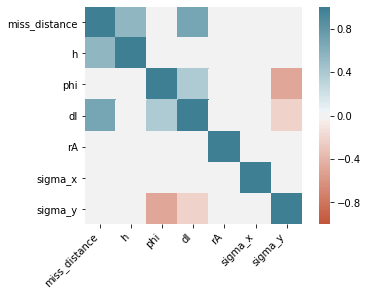

In [14]:
corr = X.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

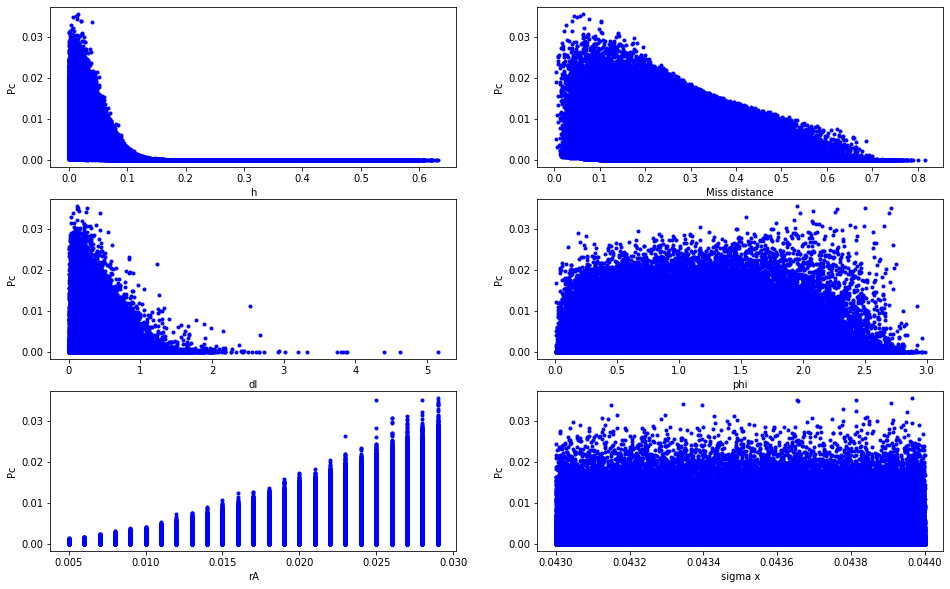

In [32]:
#plt.ylim(0., 0.001)
#plt.plot(result['h'],y['Pc_u'],'b.')

fig = plt.figure(figsize=(16, 10))

plt.subplot(3, 2, 1)
plt.ylabel('Pc')
plt.xlabel('h')
plt.plot(result['h'], y['Pc_u'],'b.')

plt.subplot(3, 2, 2)
plt.ylabel('Pc')
plt.xlabel('Miss distance')
plt.plot(result['miss_distance'], y['Pc_u'],'b.')

plt.subplot(3, 2, 3)
plt.ylabel('Pc')
plt.xlabel('dl')
plt.plot(result['dl'], y['Pc_u'],'b.')

plt.subplot(3, 2, 4)
plt.ylabel('Pc')
plt.xlabel('phi')
plt.plot(result['phi'], y['Pc_u'],'b.')

plt.subplot(3, 2, 5)
plt.ylabel('Pc')
plt.xlabel('rA')
plt.plot(result['rA'], y['Pc_u'],'b.')


plt.subplot(3, 2, 6)
plt.ylabel('Pc')
plt.xlabel('sigma x')
plt.plot(result['sigma_x'], y['Pc_u'],'b.')


plt.show()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
X_train = preprocessing.scale(X_train)

X_test = preprocessing.scale(X_test)

W0717 18:40:10.618380 29272 deprecation_wrapper.py:119] From C:\Users\Dorota Mieczkowska\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0717 18:40:10.705092 29272 deprecation_wrapper.py:119] From C:\Users\Dorota Mieczkowska\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 00448: early stopping


0.9989402140601686

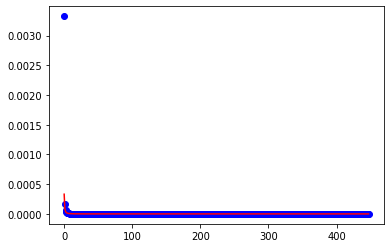

In [20]:
model = Sequential()
model.add(Dense(32, input_shape=(7,), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, ))
model.compile(Adam(lr=0.00001), 'mean_squared_error')

earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

history = model.fit(X_train, y_train, epochs = 500, validation_split = 0.2, shuffle=True, verbose = 0, callbacks = [earlystopper])
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
plt.figure()
plt.plot(loss_values,'bo',label = 'training loss')
plt.plot(val_loss_values,'r',label = 'val training loss')

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
r2_score(y_test, y_test_pred)


In [40]:
print("The R2 score on the train set is :\t{:0.5f}".format(r2_score(y_train, y_train_pred)))
print("The R2 score on the test set is :\t{:0.5f}".format(r2_score(y_test, y_test_pred)))

The R2 score on the train set is :	0.99932
The R2 score on the test set is :	0.99894


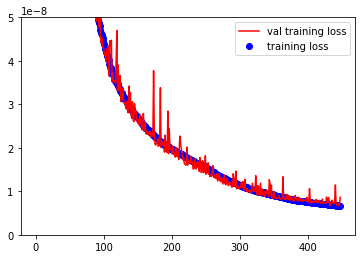

In [47]:
plt.figure()
plt.ylim(0,5e-8)
train_loss, = plt.plot(loss_values,'bo',label = 'training loss')
val_train_loss, = plt.plot(val_loss_values,'r',label = 'val training loss')
plt.legend(handles=[val_train_loss, train_loss])